In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_ccf
from statsmodels.tsa.stattools import ccf
from scipy.stats import uniform, randint

color_pal = sns.color_palette()
plt.style.use("fivethirtyeight")

# Do XGBoost with autoregressive vars

In [25]:
df = pd.read_csv('./data/daily.csv')
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [26]:
def create_date_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['week'] = df.index.isocalendar().week
    df['dayofyear'] = df.index.dayofyear
    return df

def clean_nas(df):
    df = df.copy()
    df.ffill(inplace=True)
    df.dropna(inplace=True)
    return df

In [27]:
df = create_date_features(df)
df = clean_nas(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12584 entries, 1990-01-01 to 2024-06-14
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TAVG_flag       12584 non-null  object 
 1   TAVG_origFlag   12584 non-null  object 
 2   TAVG_origValue  12584 non-null  float64
 3   TAVG_value      12584 non-null  float64
 4   WTEQ_average    12584 non-null  float64
 5   WTEQ_flag       12584 non-null  object 
 6   WTEQ_origFlag   12584 non-null  object 
 7   WTEQ_origValue  12584 non-null  float64
 8   WTEQ_value      12584 non-null  float64
 9   agency_cd       12584 non-null  object 
 10  site_no         12584 non-null  int64  
 11  CFS             12584 non-null  int64  
 12  status          12584 non-null  object 
 13  year            12584 non-null  int32  
 14  quarter         12584 non-null  int32  
 15  month           12584 non-null  int32  
 16  week            12584 non-null  UInt32 
 17  dayofyear     

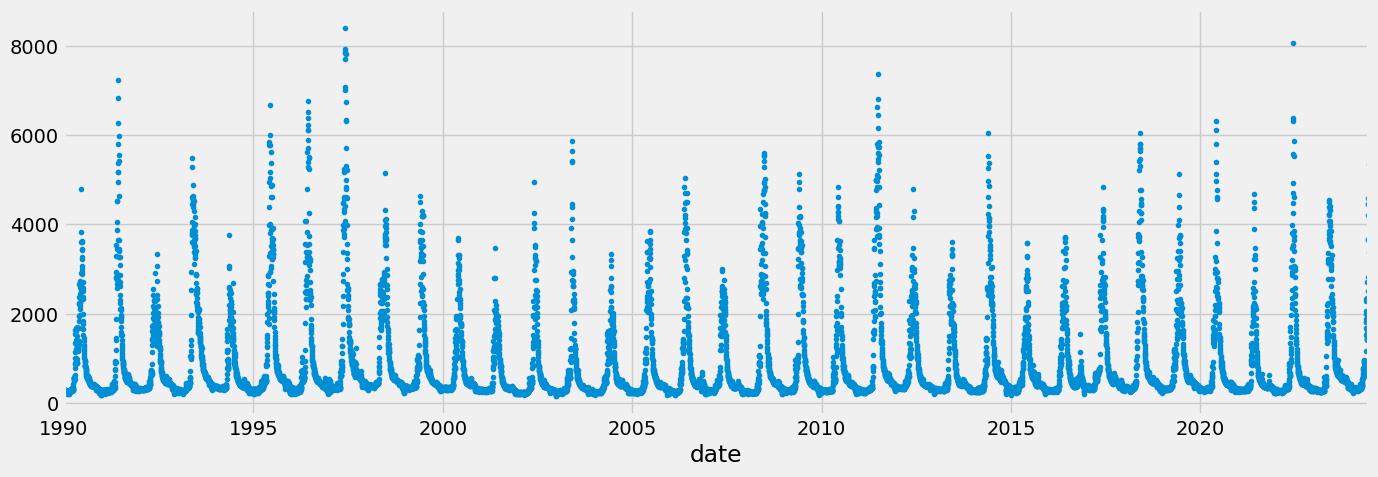

In [28]:
df['CFS'].plot(style='.', figsize=(15, 5), color=color_pal[0])
plt.show()

<Axes: ylabel='Frequency'>

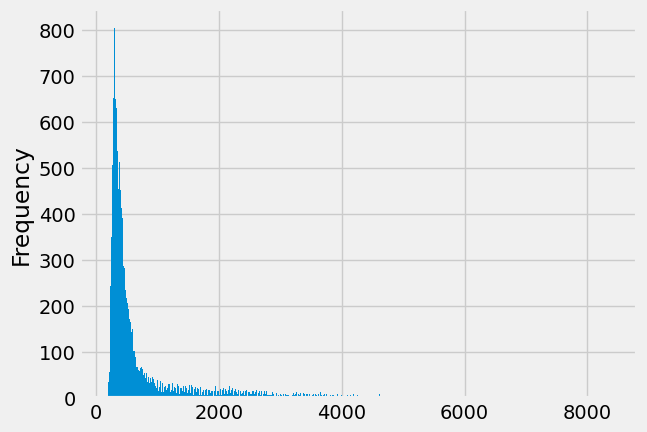

In [29]:
df["CFS"].plot(kind='hist', bins=500)

<Axes: ylabel='Frequency'>

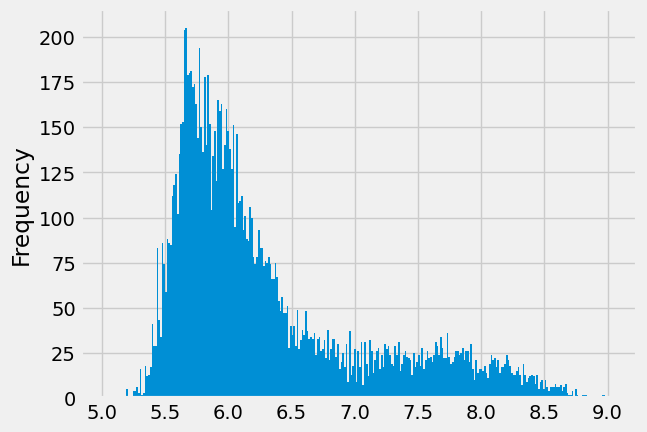

In [30]:
np.log(df["CFS"]).plot(kind='hist', bins=300)

# Exploration and TS Analysis

In [31]:
TARGET = 'CFS'
FEATURES = ['TAVG_origValue', 'WTEQ_average', 'WTEQ_origValue',
            'year', 'quarter', 'month', 'week', 'dayofyear']
df = df[[*FEATURES, TARGET]]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12584 entries, 1990-01-01 to 2024-06-14
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TAVG_origValue  12584 non-null  float64
 1   WTEQ_average    12584 non-null  float64
 2   WTEQ_origValue  12584 non-null  float64
 3   year            12584 non-null  int32  
 4   quarter         12584 non-null  int32  
 5   month           12584 non-null  int32  
 6   week            12584 non-null  UInt32 
 7   dayofyear       12584 non-null  int32  
 8   CFS             12584 non-null  int64  
dtypes: UInt32(1), float64(3), int32(4), int64(1)
memory usage: 749.6 KB


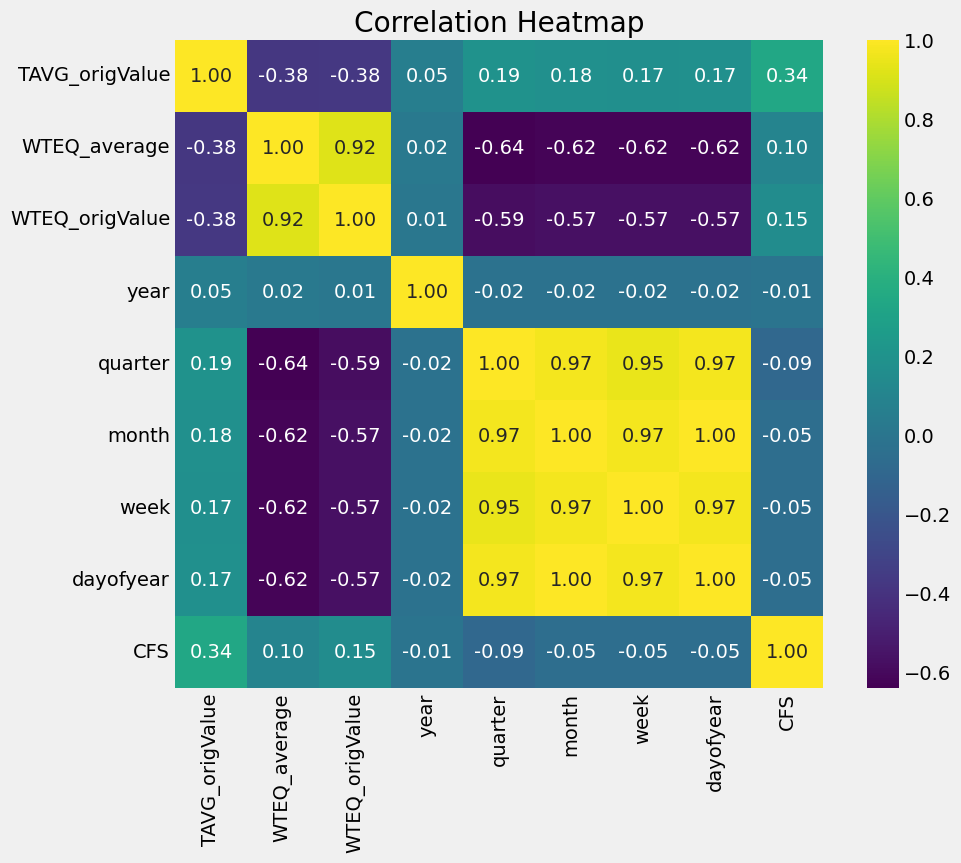

In [32]:
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', square=True)
plt.title('Correlation Heatmap')
plt.show()

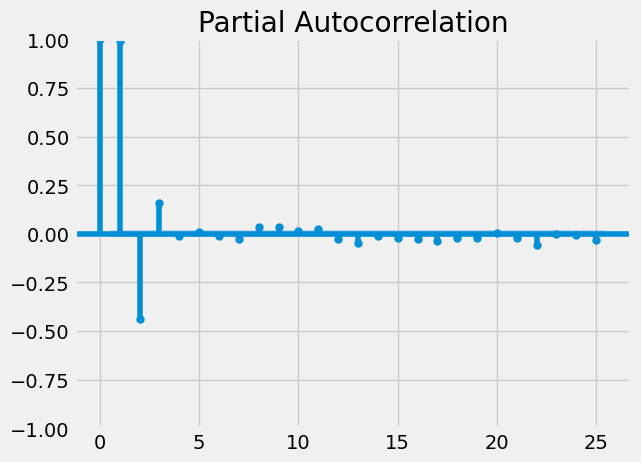

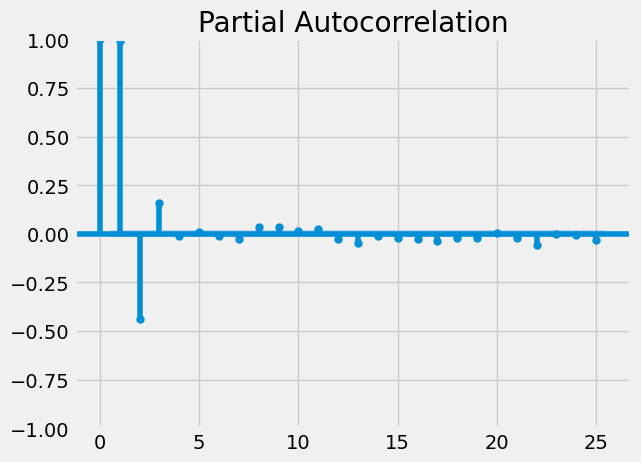

In [33]:
plot_pacf(df['CFS'], lags=25)
# go find your r script looking at this because these plots suck (exploratory_with_snotel.R)

# Train test split for CV

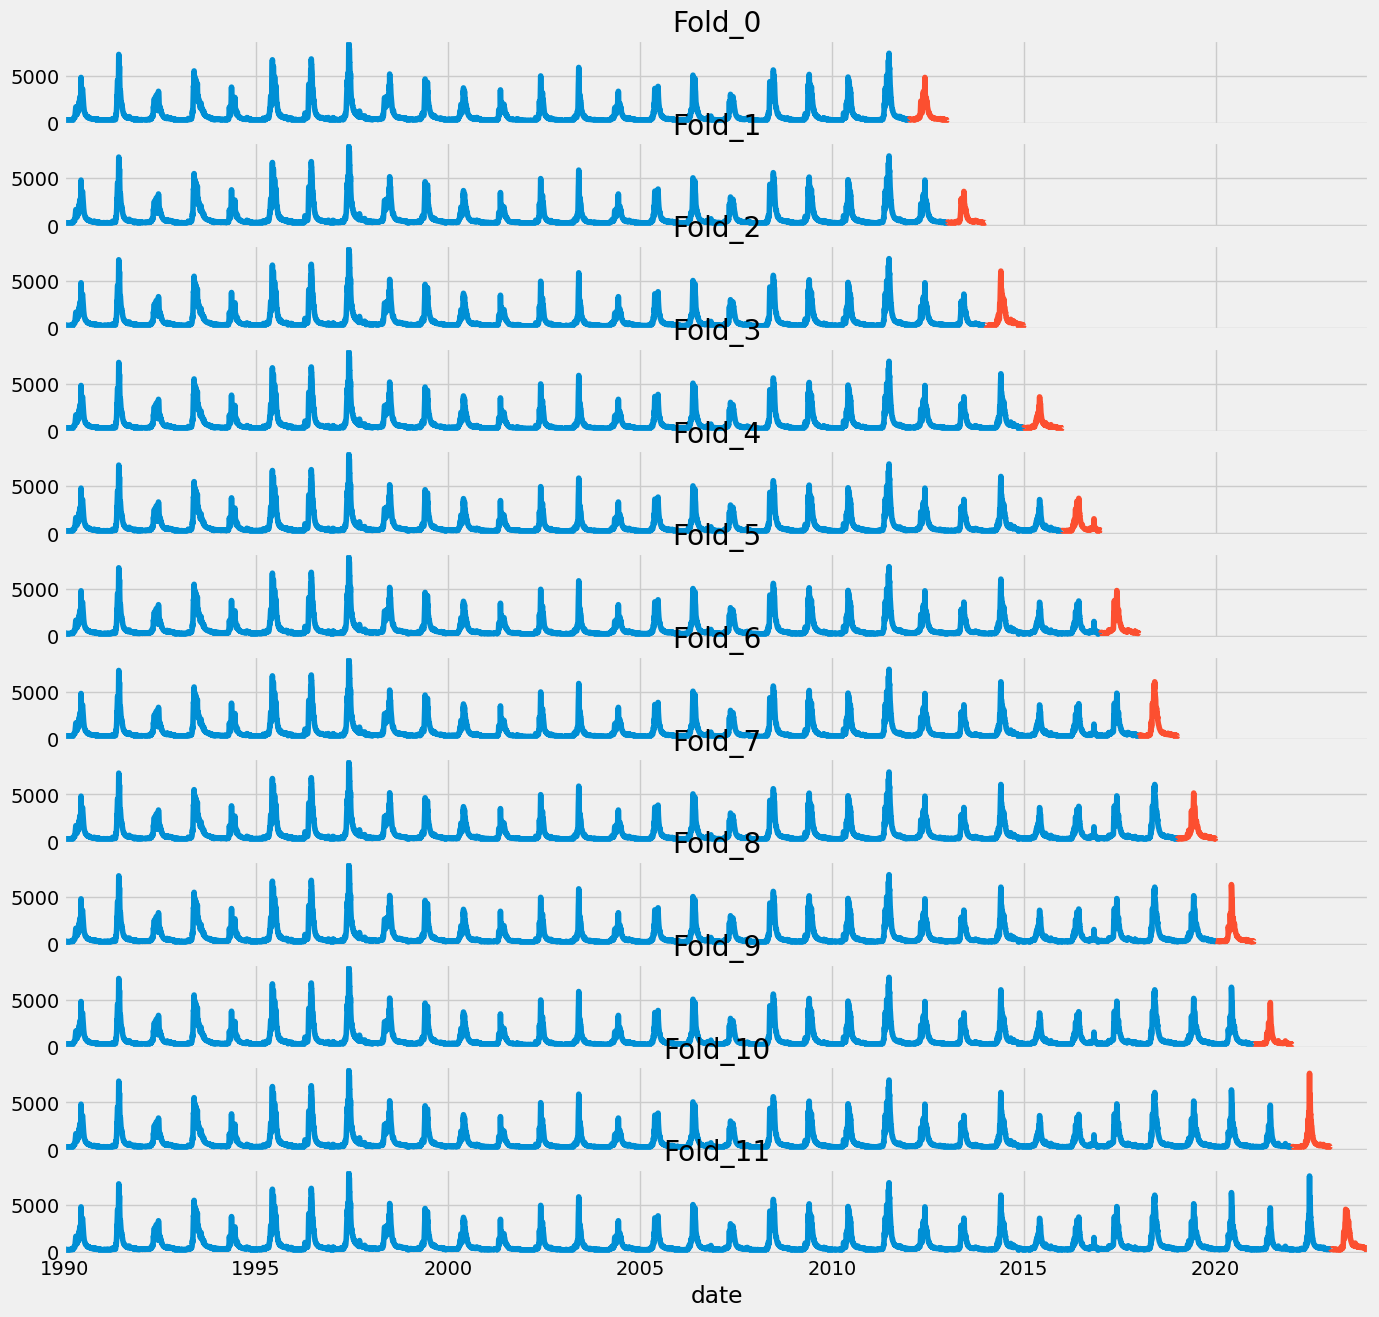

In [11]:
splits = 12
tss = TimeSeriesSplit(n_splits=splits, test_size=365, gap=0)
df = df.sort_index()
cutoff = pd.to_datetime('2024-01-01')
df_h = df.loc[df.index > cutoff]
df_tss = df.loc[df.index <= cutoff]
fig, axs = plt.subplots(splits, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df_tss):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train["CFS"].plot(ax=axs[fold], label="TRAIN", title=f"Fold_{fold}")
    test["CFS"].plot(ax=axs[fold], label="TEST")
    fold += 1
plt.show()

## Make features

In [34]:
def add_cfs_lags(df):
    target_map = df['CFS'].to_dict()
    df['CFS_lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['CFS_lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['CFS_lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['CFS_lag365'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    return df

def add_temp_lags(df):
    target_map = df['TAVG_origValue'].to_dict()
    df['TAVG_lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['TAVG_lag2'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['TAVG_lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['TAVG_lag365'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    return df

def add_first_difference(df, column_name='WTEQ_origValue'):
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame")

    diff_column_name = f'{column_name}_diff'
    df[diff_column_name] = df[column_name].diff()

    return df

In [35]:
df = add_cfs_lags(df)
df = add_temp_lags(df)
df = add_first_difference(df)

In [36]:
df.head()

,TAVG_origValue,WTEQ_average,WTEQ_origValue,year,quarter,month,week,dayofyear,CFS,CFS_lag1,CFS_lag2,CFS_lag3,CFS_lag365,TAVG_lag1,TAVG_lag2,TAVG_lag3,TAVG_lag365,WTEQ_origValue_diff
date,,,,,,,,,,,,,,,,,,
1990-01-01,19.2,9.9,11.4,1990,1,1,1,1,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-02,10.9,10.0,11.8,1990,1,1,1,2,290,275.0,NaN,NaN,NaN,19.2,NaN,NaN,NaN,0.4
1990-01-03,3.9,10.1,11.8,1990,1,1,1,3,258,290.0,275.0,NaN,NaN,10.9,19.2,NaN,NaN,0.0
1990-01-04,11.5,10.2,12.0,1990,1,1,1,4,249,258.0,290.0,275.0,NaN,3.9,10.9,19.2,NaN,0.2
1990-01-05,14.5,10.3,12.0,1990,1,1,1,5,269,249.0,258.0,290.0,NaN,11.5,3.9,10.9,NaN,0.0


# Run XGB with cv

In [15]:
splits = 12
tss = TimeSeriesSplit(n_splits=splits, test_size=365, gap=0)
df = df.sort_index()

fold = 0
preds = []
scores = []
mapes = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    TARGET = 'CFS'
    FEATURES = ['TAVG_origValue', 'WTEQ_average', 'WTEQ_origValue',
                'CFS_lag1', 'CFS_lag2', 'CFS_lag365', 'TAVG_lag1', 'TAVG_lag2',
                'TAVG_lag365', 'WTEQ_origValue_diff',
                'year', 'quarter', 'month', 'week', 'dayofyear']

    X_train = train[FEATURES]
    y_train = np.log(train[TARGET])

    X_test = test[FEATURES]
    y_test = np.log(test[TARGET])

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=1000, early_stopping_rounds=50,
                          objective='reg:squarederror', max_depth=3, learning_rate=.01)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
           verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred)) # NOTE! non-exponentiated: ie log units
    mape = mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred)) # NOTE! exponentiated: ie normal CFS
    scores.append(score)
    mapes.append(mape)
    fold += 1
    print(f'#### Finished fold {fold} of {splits} ####')
print(f'RMSE Avg across folds {np.mean(scores):0.4f}')
print(f'MAPE Avg across foles {np.mean(mapes):0.4f}')

[0]	validation_0-rmse:5.80313	validation_1-rmse:5.71826
[100]	validation_0-rmse:2.12885	validation_1-rmse:2.09443
[200]	validation_0-rmse:0.78414	validation_1-rmse:0.76943
[300]	validation_0-rmse:0.29512	validation_1-rmse:0.28291
[400]	validation_0-rmse:0.12383	validation_1-rmse:0.11235
[500]	validation_0-rmse:0.07254	validation_1-rmse:0.06318
[600]	validation_0-rmse:0.06049	validation_1-rmse:0.05326
[700]	validation_0-rmse:0.05747	validation_1-rmse:0.05145
[800]	validation_0-rmse:0.05586	validation_1-rmse:0.05088
[900]	validation_0-rmse:0.05480	validation_1-rmse:0.05060
[999]	validation_0-rmse:0.05389	validation_1-rmse:0.05039
#### Finished fold 1 of 12 ####
[0]	validation_0-rmse:5.79954	validation_1-rmse:5.73513
[100]	validation_0-rmse:2.12743	validation_1-rmse:2.10799
[200]	validation_0-rmse:0.78354	validation_1-rmse:0.77690
[300]	validation_0-rmse:0.29482	validation_1-rmse:0.28994
[400]	validation_0-rmse:0.12364	validation_1-rmse:0.11790
[500]	validation_0-rmse:0.07228	validation_1

In [16]:
print(f'RMSE Avg across folds {np.mean(scores):0.4f}')
print(f'MAPE Avg across foles {np.mean(mapes):0.4f}')
print(f'\n Scores: {scores}')
print(f'\n MAPES: {(mapes)}')

RMSE Avg across folds 0.0576
MAPE Avg across foles 0.0392

 Scores: [np.float64(0.050391246345944725), np.float64(0.05251230391555281), np.float64(0.06372538300524001), np.float64(0.05479287159653104), np.float64(0.07937269576532897), np.float64(0.05205607224046839), np.float64(0.05446158255158316), np.float64(0.054287730222042245), np.float64(0.05228760904236603), np.float64(0.06928835558036212), np.float64(0.04826407064089967), np.float64(0.05953448603843994)]

 MAPES: [np.float64(0.03721020414185853), np.float64(0.03716041761623511), np.float64(0.04419793094464518), np.float64(0.038970279970975776), np.float64(0.04472728747570232), np.float64(0.0374584900948734), np.float64(0.0368664638840569), np.float64(0.03790337130654859), np.float64(0.037650102573106865), np.float64(0.04405604725831385), np.float64(0.034276535278975395), np.float64(0.040322764037748586)]


## Hyperparameter tuning:

In [37]:
splits = 12
tss = TimeSeriesSplit(n_splits=splits, test_size=365, gap=0)
df = df.sort_index()
# Also holdout this year
cutoff = pd.to_datetime('2024-01-01')
df_holdout = df.loc[df.index > cutoff]
df = df.loc[df.index <= cutoff]


fold = 0
preds = []
scores = []
mapes = []
best_params = []

param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0, 0.5),
    'alpha': uniform(0, 1),
    'lambda': uniform(0, 1),
}

TARGET = 'CFS'
FEATURES = ['WTEQ_average', 'CFS_lag1', 'CFS_lag2', 'CFS_lag3', 'CFS_lag365',
            'quarter', 'month', 'week', 'dayofyear']

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    X_train = train[FEATURES]
    y_train = np.log(train[TARGET])

    X_test = test[FEATURES]
    y_test = np.log(test[TARGET])

    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', base_score=0.5, booster='gbtree')

    # Set up RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_dist,
        n_iter=100,
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)

    best_model = random_search.best_estimator_

    y_pred = best_model.predict(X_test)
    preds.append(y_pred)

    # Calculate metrics
    score = np.sqrt(mean_squared_error(y_test, y_pred)) # also still in log
    mape = mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred)) # NOT in log: ie in CFS
    scores.append(score)
    mapes.append(mape)
    best_params.append(random_search.best_params_)

    fold += 1
    print(f'#### Finished fold {fold} of {splits} ####')
    print(f'Best parameters: {random_search.best_params_}')
    print(f'RMSE: {score}')
    print(f'MAPE: {mape}')
    print('-------------------')

# Print overall results
print(f'Average RMSE: {np.mean(scores)}')
print(f'Average MAPE: {np.mean(mapes)}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
#### Finished fold 1 of 12 ####
Best parameters: {'alpha': np.float64(0.6174815096277165), 'colsample_bytree': np.float64(0.8446612641953124), 'gamma': np.float64(0.003533152609858703), 'lambda': np.float64(0.023062425041415757), 'learning_rate': np.float64(0.16743239807751675), 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 343, 'subsample': np.float64(0.836965827544817)}
RMSE: 0.07285015006385497
MAPE: 0.0497002011645884
-------------------
Fitting 3 folds for each of 100 candidates, totalling 300 fits
#### Finished fold 2 of 12 ####
Best parameters: {'alpha': np.float64(0.6174815096277165), 'colsample_bytree': np.float64(0.8446612641953124), 'gamma': np.float64(0.003533152609858703), 'lambda': np.float64(0.023062425041415757), 'learning_rate': np.float64(0.16743239807751675), 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 343, 'subsample': np.float64(0.836965827544817)}
RMSE: 0.06154505999702063
MAPE: 0.0

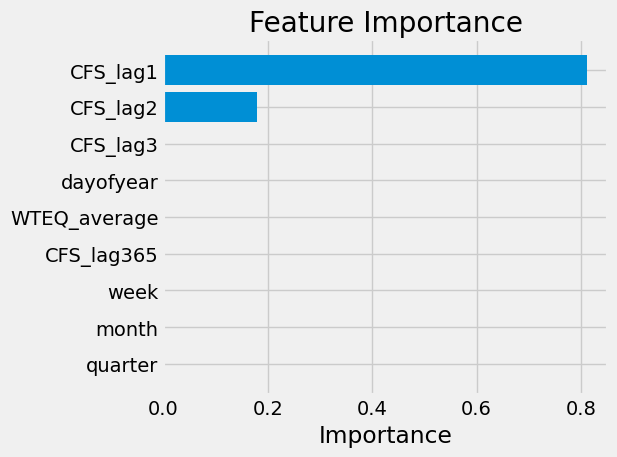

In [38]:
# FEATURES = ['TAVG_origValue', 'WTEQ_average', 'WTEQ_origValue',
#             'CFS_lag1', 'CFS_lag2', 'CFS_lag365', 'TAVG_lag1', 'TAVG_lag2',
#             'TAVG_lag365', 'WTEQ_origValue_diff',
#             'quarter', 'month', 'week', 'dayofyear']
# Average RMSE: 0.05455613902274042 
# Average MAPE: 0.03724703573183385
importance = best_model.feature_importances_
sorted_idx = importance.argsort()
plt.barh(range(len(sorted_idx)), importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), [FEATURES[i] for i in sorted_idx])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

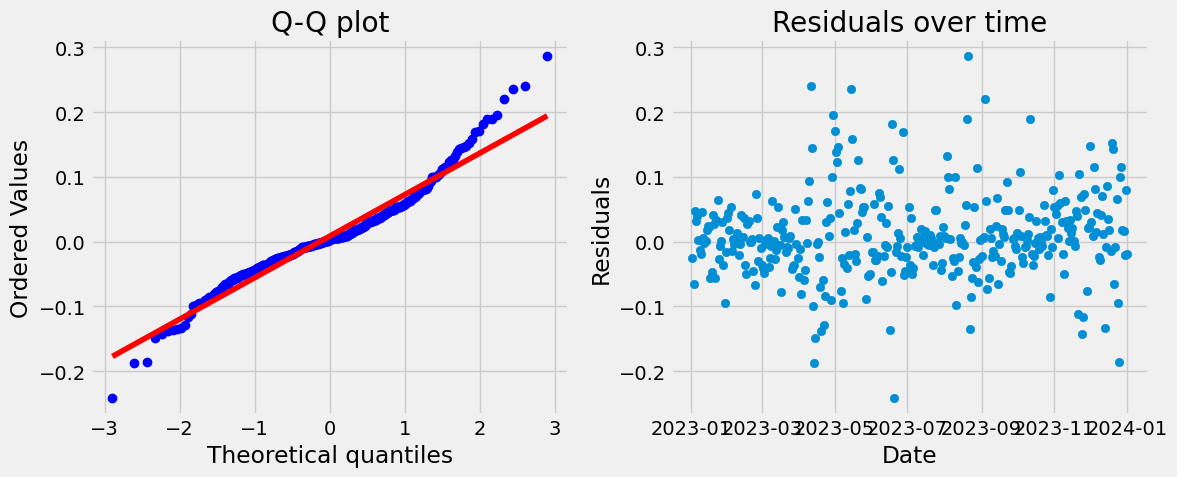

In [19]:
import scipy.stats as stats

residuals = y_test - y_pred
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

stats.probplot(residuals, dist="norm", plot=ax1)
ax1.set_title("Q-Q plot")

ax2.scatter(test.index, residuals)
ax2.set_title("Residuals over time")
ax2.set_xlabel("Date")
ax2.set_ylabel("Residuals")

plt.tight_layout()
plt.show()

## Checkout forecast for 2024

In [20]:
best_params = {
    'alpha': 0.2721322493846353,
    'colsample_bytree': 0.8590760482165449,
    'gamma': 0.0002601884976579094,
    'lambda': 0.352568856334169,
    'learning_rate': 0.1014343774474087,
    'max_depth': 6,
    'min_child_weight': 8,
    'n_estimators': 510,
    'subsample': 0.7669644012595116
}

full_model = xgb.XGBRegressor(objective='reg:squarederror', base_score=0.5, booster='gbtree', **best_params)
full_model.fit(df[FEATURES], np.log(df[TARGET]))
future = pd.date_range("2024-01-02", "2024-06-14", freq="1d")
future_df = pd.DataFrame(index=future)
future_df['is_future'] = True
future_df['CFS'] = df_holdout['CFS']
for f in FEATURES:
    future_df[f] = df_holdout[f]

df['is_future'] = False
df_and_future = pd.concat([df, future_df])
df_and_future['CFS_pred'] = np.exp(full_model.predict(df_and_future[FEATURES]))

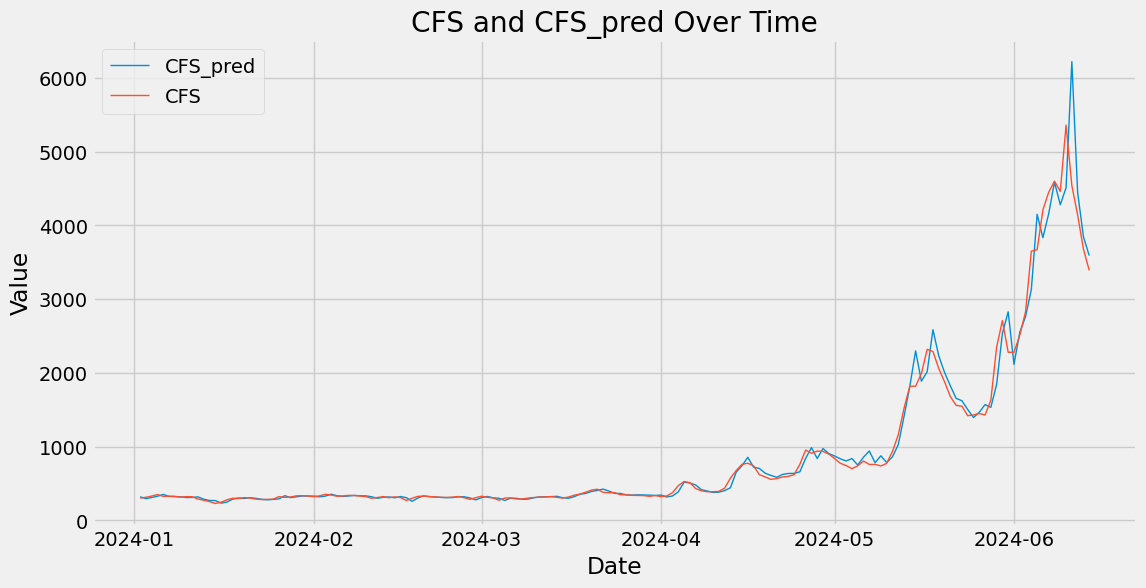

In [21]:
future_data = df_and_future.query('is_future')

plt.figure(figsize=(12, 6))
plt.plot(future_data.index, future_data['CFS_pred'], label='CFS_pred', lw=1)
plt.plot(future_data.index, future_data['CFS'], label='CFS', lw=1)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('CFS and CFS_pred Over Time')
plt.legend()
plt.savefig('xgb_preds_2024.jpg', format='jpg', dpi=200, bbox_inches='tight')
plt.show()

In [22]:
print(f"MAPE: {mean_absolute_percentage_error(future_data['CFS'], future_data['CFS_pred'])}")

MAPE: 0.06057944258319609


# Next: Hybrid model (xgb + prophet)
## use prophet to forecast the covariates